In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sktime.forecasting.arch import ARCH
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. data

In [2]:
TICKER = "BZ=F"
START = "2010-01-01"
END = "2025-06-30"
data = yf.download(TICKER, start=START, end=END, progress=False)
spot = data['Close'][TICKER]
returns = np.log(spot / spot.shift(1)).dropna()
returns.index = pd.PeriodIndex(returns.index, freq='D')
TRAIN_START = START
TRAIN_END = "2023-12-31"
TEST_START = "2024-01-01"
TEST_END = END

train_returns = returns[TRAIN_START:TEST_START]
test_returns = returns[TEST_START:TEST_END]


C:\Users\Szymon.Stolarski\AppData\Local\Temp\ipykernel_18176\4014083244.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=START, end=END, progress=False)


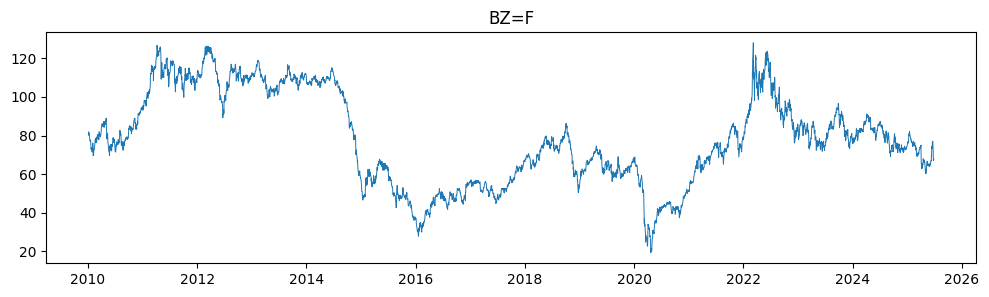

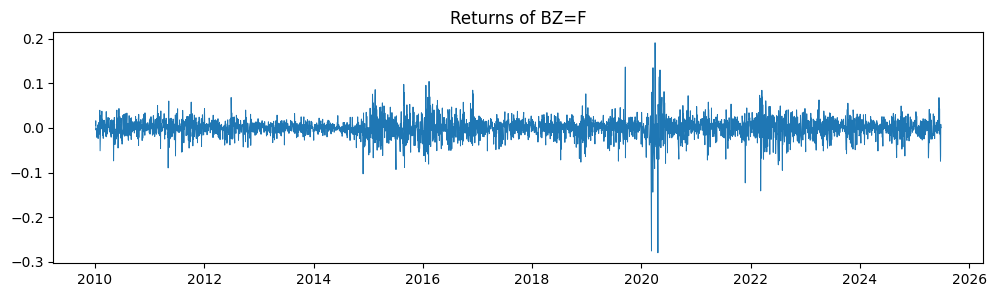

In [3]:
plt.figure(figsize=(12,3))
plt.plot(spot, linewidth=0.7)
plt.title(TICKER)
plt.show()

plt.figure(figsize=(12,3))
plt.plot(returns.index.to_timestamp(), returns.values, label='Daily Returns', linewidth=0.7)
plt.title(f"Returns of {TICKER}")
plt.show()

# 2. Models
## 2.1. GARCH

In [4]:
# Fit ARCH model on returns
forecaster = ARCH(p=1, q=1, mean='Zero', dist="Normal", vol='GARCH', method='analytic', random_state=42, rescale=False)
forecaster.fit(train_returns)
print(forecaster.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   BZ=F   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                8784.99
Distribution:                  Normal   AIC:                          -17564.0
Method:            Maximum Likelihood   BIC:                          -17545.5
                                        No. Observations:                 3488
Date:                Sun, Sep 21 2025   Df Residuals:                     3488
Time:                        19:47:23   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.0662e-05  6.829e-12  1.561e+06      0.000 [1.

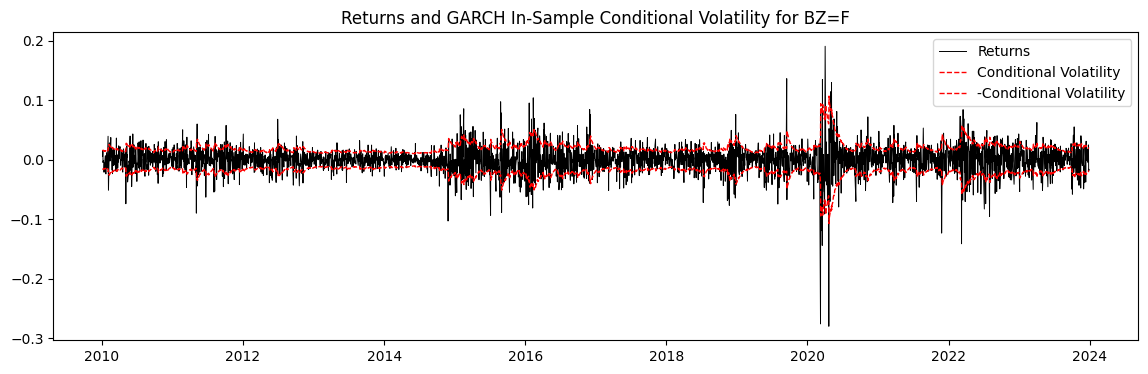

In [5]:
# Get in-sample conditional variance predictions
conditional_volatility_in_sample = forecaster._fitted_forecaster.conditional_volatility
conditional_volatility_in_sample = np.sqrt(forecaster.predict_var(fh=train_returns.index))

plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns', color='black', linewidth=0.7)
plt.plot(conditional_volatility_in_sample.index.to_timestamp(), conditional_volatility_in_sample.values, label='Conditional Volatility', color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_in_sample.index.to_timestamp(), -1 * conditional_volatility_in_sample.values, label='-Conditional Volatility', color='red', linestyle='--', linewidth=1)
plt.title(f"Returns and GARCH In-Sample Conditional Volatility for {TICKER}")
plt.legend()
plt.show()

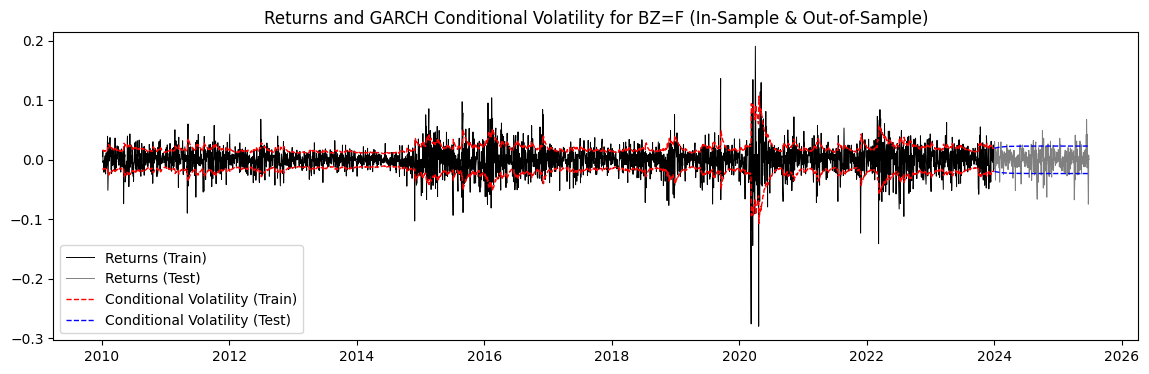

In [6]:
conditional_volatility_out_of_sample = np.sqrt(forecaster.predict_var(fh=test_returns.index))
plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(conditional_volatility_in_sample.index.to_timestamp(), conditional_volatility_in_sample.values, label='Conditional Volatility (Train)', color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_in_sample.index.to_timestamp(), -1 * conditional_volatility_in_sample.values, color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample.index.to_timestamp(), conditional_volatility_out_of_sample.values, label='Conditional Volatility (Test)', color='blue', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample.index.to_timestamp(), -1 * conditional_volatility_out_of_sample.values, color='blue', linestyle='--', linewidth=1)
plt.title(f"Returns and GARCH Conditional Volatility for {TICKER} (In-Sample & Out-of-Sample)")
plt.legend()
plt.show()

In [7]:
# Forecasted volatility (out-of-sample)
forecast_vol = conditional_volatility_out_of_sample.loc[test_returns.index]

# Realized volatility: use squared returns as a proxy
realized_vol = np.sqrt(test_returns ** 2)

# Metrics
mse = mean_squared_error(realized_vol, forecast_vol)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realized_vol, forecast_vol)
corr = np.corrcoef(realized_vol, forecast_vol)[0, 1]

print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Correlation (Realized vs Forecasted Volatility): {corr:.4f}")

Mean Squared Error (MSE): 0.000236
Root Mean Squared Error (RMSE): 0.015366
Mean Absolute Error (MAE): 0.013270
Correlation (Realized vs Forecasted Volatility): 0.0354


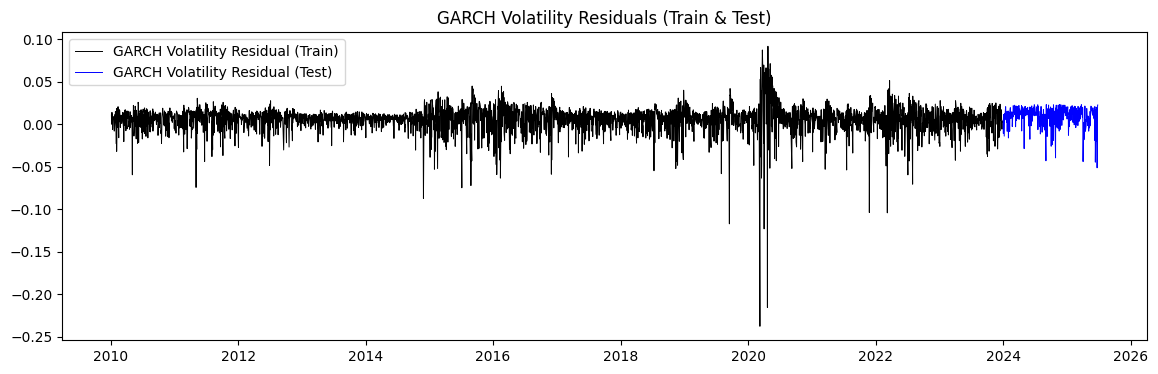

In [8]:
GARCH_volatility_residual_train = conditional_volatility_in_sample - np.sqrt(train_returns**2)
GARCH_volatility_residual_test = forecast_vol - realized_vol

plt.figure(figsize=(14, 4))
plt.plot(GARCH_volatility_residual_train.index.to_timestamp(), GARCH_volatility_residual_train.values, label='GARCH Volatility Residual (Train)', color='black', linewidth=0.7)
plt.plot(GARCH_volatility_residual_test.index.to_timestamp(), GARCH_volatility_residual_test.values, label='GARCH Volatility Residual (Test)', color='blue', linewidth=0.7)
plt.title("GARCH Volatility Residuals (Train & Test)")
plt.legend()
plt.show()

## 2.2. GJR-GARCH

In [9]:
# Fit ARCH model on returns
forecaster = ARCH(p=1, q=1, o=1, mean='Zero', dist="Normal", vol='GARCH', method='analytic', random_state=42, rescale=False)
forecaster.fit(train_returns)
print(forecaster.summary())

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                   BZ=F   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                8805.47
Distribution:                  Normal   AIC:                          -17602.9
Method:            Maximum Likelihood   BIC:                          -17578.3
                                        No. Observations:                 3488
Date:                Sun, Sep 21 2025   Df Residuals:                     3488
Time:                        19:47:26   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.0556e-05  8.196e-12  1.288e+06      0.000 [1.

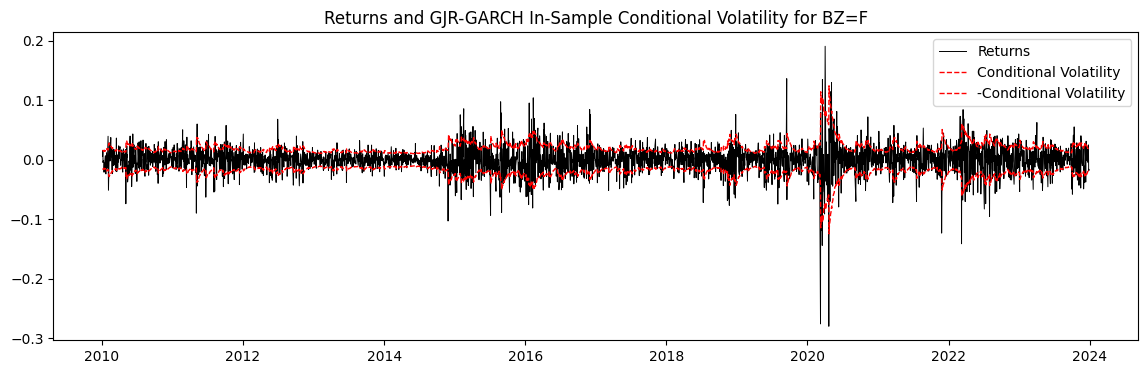

In [10]:
# Get in-sample conditional variance predictions
conditional_volatility_in_sample = forecaster._fitted_forecaster.conditional_volatility
conditional_volatility_in_sample = np.sqrt(forecaster.predict_var(fh=train_returns.index))

plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns', color='black', linewidth=0.7)
plt.plot(conditional_volatility_in_sample.index.to_timestamp(), conditional_volatility_in_sample.values, label='Conditional Volatility', color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_in_sample.index.to_timestamp(), -1 * conditional_volatility_in_sample.values, label='-Conditional Volatility', color='red', linestyle='--', linewidth=1)
plt.title(f"Returns and GJR-GARCH In-Sample Conditional Volatility for {TICKER}")
plt.legend()
plt.show()

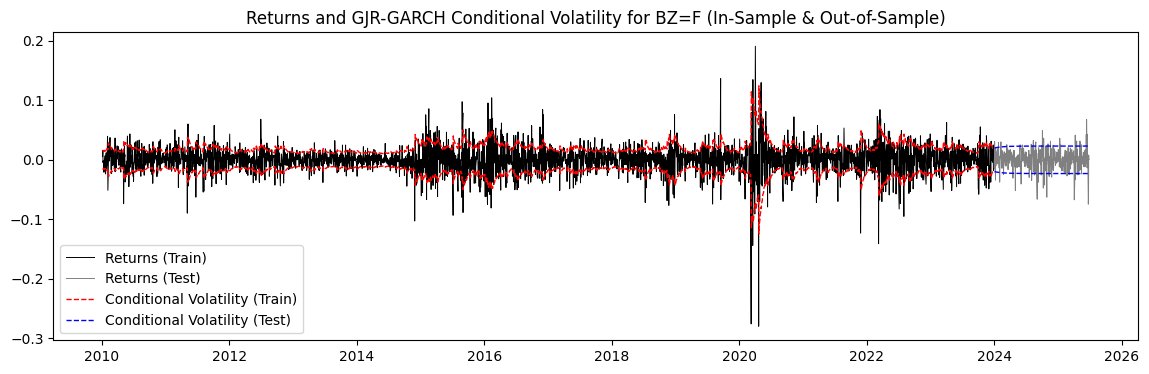

In [11]:
conditional_volatility_out_of_sample = np.sqrt(forecaster.predict_var(fh=test_returns.index))
plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(conditional_volatility_in_sample.index.to_timestamp(), conditional_volatility_in_sample.values, label='Conditional Volatility (Train)', color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_in_sample.index.to_timestamp(), -1 * conditional_volatility_in_sample.values, color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample.index.to_timestamp(), conditional_volatility_out_of_sample.values, label='Conditional Volatility (Test)', color='blue', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample.index.to_timestamp(), -1 * conditional_volatility_out_of_sample.values, color='blue', linestyle='--', linewidth=1)
plt.title(f"Returns and GJR-GARCH Conditional Volatility for {TICKER} (In-Sample & Out-of-Sample)")
plt.legend()
plt.show()

In [12]:
# Forecasted volatility (out-of-sample)
forecast_vol = conditional_volatility_out_of_sample.loc[test_returns.index]

# Realized volatility: use squared returns as a proxy
realized_vol = np.sqrt(test_returns ** 2)

# Metrics
mse = mean_squared_error(realized_vol, forecast_vol)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realized_vol, forecast_vol)
corr = np.corrcoef(realized_vol, forecast_vol)[0, 1]

print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Correlation (Realized vs Forecasted Volatility): {corr:.4f}")

Mean Squared Error (MSE): 0.000237
Root Mean Squared Error (RMSE): 0.015380
Mean Absolute Error (MAE): 0.013289
Correlation (Realized vs Forecasted Volatility): 0.0365


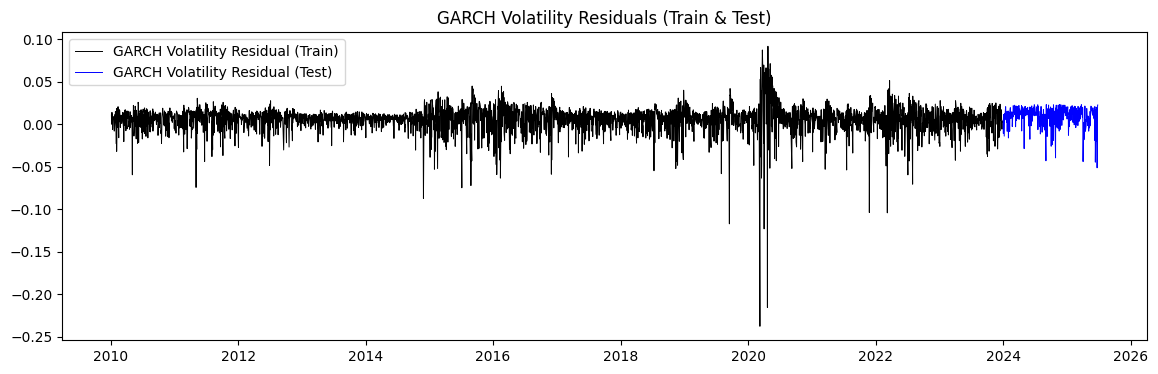

In [13]:
GJR_GARCH_volatility_residual_train = conditional_volatility_in_sample - np.sqrt(train_returns**2)
GJR_GARCH_volatility_residual_test = forecast_vol - realized_vol

plt.figure(figsize=(14, 4))
plt.plot(GARCH_volatility_residual_train.index.to_timestamp(), GARCH_volatility_residual_train.values, label='GARCH Volatility Residual (Train)', color='black', linewidth=0.7)
plt.plot(GARCH_volatility_residual_test.index.to_timestamp(), GARCH_volatility_residual_test.values, label='GARCH Volatility Residual (Test)', color='blue', linewidth=0.7)
plt.title("GARCH Volatility Residuals (Train & Test)")
plt.legend()
plt.show()

## 2.3. XGBoost
### 2.3.1. With only lagged returns as input

In [14]:
from xgboost import XGBRegressor

# Prepare lagged features for XGBoost: use past days' returns as predictors
n_lags = 1

def make_lagged_features(series, n_lags):
    df = pd.concat([series.shift(i) for i in range(1, n_lags + 1)], axis=1)
    df.columns = [f"lag_{i}" for i in range(1, n_lags + 1)]
    return df

# Training set
X_train_lagged = make_lagged_features(train_returns, n_lags).dropna()
y_train_lagged = (train_returns ** 2).loc[X_train_lagged.index] # variance

# Test set
X_test_lagged = make_lagged_features(test_returns, n_lags).dropna()
y_test_lagged = (test_returns ** 2).loc[X_test_lagged.index] # variance

# Fit XGBoost regressor
xgb = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
xgb.fit(X_train_lagged, y_train_lagged)

# Predict
y_pred_xgb = xgb.predict(X_test_lagged)

# Forecasted volatility (out-of-sample)
forecast_vol = np.sqrt(y_pred_xgb)
# Realized volatility
realized_vol = np.sqrt(y_test_lagged)

# Evaluate
mse_xgb = mean_squared_error(realized_vol, forecast_vol)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(realized_vol, forecast_vol)
corr_xgb = np.corrcoef(realized_vol, forecast_vol)[0, 1]


print(f"XGBoost - MSE: {mse_xgb:.6f}")
print(f"XGBoost - RMSE: {rmse_xgb:.6f}")
print(f"XGBoost - MAE: {mae_xgb:.6f}")
print(f"XGBoost - Correlation: {corr_xgb:.4f}")

# In-sample prediction (train set)
y_pred_xgb_train = xgb.predict(X_train_lagged)



XGBoost - MSE: 0.000207
XGBoost - RMSE: 0.014378
XGBoost - MAE: 0.011979
XGBoost - Correlation: 0.0480


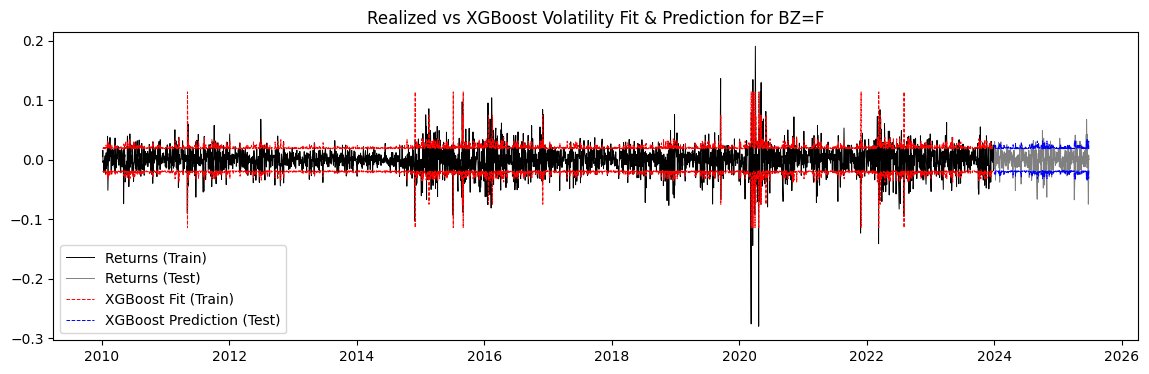

In [15]:
plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
# plt.plot(y_train_lagged.index.to_timestamp(), y_train_lagged.values, label='Realized Volatility (Train)', color='black', linewidth=0.7)
# plt.plot(y_test_lagged.index.to_timestamp(), y_test_lagged.values, label='Realized Volatility (Test)', color='gray', linewidth=0.7)
plt.plot(y_train_lagged.index.to_timestamp(), np.sqrt(y_pred_xgb_train), label='XGBoost Fit (Train)', color='red', linestyle='--', linewidth=0.7)
plt.plot(y_test_lagged.index.to_timestamp(), np.sqrt(y_pred_xgb), label='XGBoost Prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(y_train_lagged.index.to_timestamp(), -np.sqrt(y_pred_xgb_train), color='red', linestyle='--', linewidth=0.7)
plt.plot(y_test_lagged.index.to_timestamp(), -np.sqrt(y_pred_xgb), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"Realized vs XGBoost Volatility Fit & Prediction for {TICKER}")
plt.legend()
plt.show()

### 2.3.2. do not use Lagged returns and past variance

In [16]:
# from xgboost import XGBRegressor

# # Prepare lagged features for XGBoost: use past days' returns as predictors
# n_lags = 1

# def make_lagged_features(series, n_lags):
#     # Lagged returns
#     lagged_returns = [series.shift(i) for i in range(1, n_lags + 1)]
#     # Lagged realized variance (squared returns)
#     lagged_var = [(series ** 2).shift(i) for i in range(1, n_lags + 1)]
#     df = pd.concat(lagged_returns + lagged_var, axis=1)
#     df.columns = [f"lag_ret_{i}" for i in range(1, n_lags + 1)] + [f"lag_var_{i}" for i in range(1, n_lags + 1)]
#     return df

# # Training set
# X_train_lagged = make_lagged_features(train_returns, n_lags).dropna()
# y_train_lagged = (train_returns ** 2).loc[X_train_lagged.index] # variance

# # Test set
# X_test_lagged = make_lagged_features(test_returns, n_lags).dropna()
# y_test_lagged = (test_returns ** 2).loc[X_test_lagged.index] # variance

# # Fit XGBoost regressor
# xgb = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
# xgb.fit(X_train_lagged, y_train_lagged)

# # Predict
# y_pred_xgb = xgb.predict(X_test_lagged)

# # Forecasted volatility (out-of-sample)
# forecast_vol = np.sqrt(y_pred_xgb)
# # Realized volatility
# realized_vol = np.sqrt(y_test_lagged)

# # Evaluate
# mse_xgb = mean_squared_error(realized_vol, forecast_vol)
# rmse_xgb = np.sqrt(mse_xgb)
# mae_xgb = mean_absolute_error(realized_vol, forecast_vol)
# corr_xgb = np.corrcoef(realized_vol, forecast_vol)[0, 1]


# print(f"XGBoost - MSE: {mse_xgb:.6f}")
# print(f"XGBoost - RMSE: {rmse_xgb:.6f}")
# print(f"XGBoost - MAE: {mae_xgb:.6f}")
# print(f"XGBoost - Correlation: {corr_xgb:.4f}")

# # In-sample prediction (train set)
# y_pred_xgb_train = xgb.predict(X_train_lagged)



In [17]:
# plt.figure(figsize=(14, 4))
# plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
# plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
# # plt.plot(y_train_lagged.index.to_timestamp(), y_train_lagged.values, label='Realized Volatility (Train)', color='black', linewidth=0.7)
# # plt.plot(y_test_lagged.index.to_timestamp(), y_test_lagged.values, label='Realized Volatility (Test)', color='gray', linewidth=0.7)
# plt.plot(y_train_lagged.index.to_timestamp(), np.sqrt(y_pred_xgb_train), label='XGBoost Fit (Train)', color='red', linestyle='--', linewidth=0.7)
# plt.plot(y_test_lagged.index.to_timestamp(), np.sqrt(y_pred_xgb), label='XGBoost Prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
# plt.plot(y_train_lagged.index.to_timestamp(), -np.sqrt(y_pred_xgb_train), color='red', linestyle='--', linewidth=0.7)
# plt.plot(y_test_lagged.index.to_timestamp(), -np.sqrt(y_pred_xgb), color='blue', linestyle='--', linewidth=0.7)
# plt.title(f"Realized vs XGBoost Volatility Fit & Prediction for {TICKER}")
# plt.legend()
# plt.show()

## 2.4. Hybrid: GARCH-XGBoost/GJR-GARCH - XGBoost
1. Take residuals from GARCH (forecasted volatility - realised volatility) both from insample (train) and out of sample (test)
2. Fit the XGBoost model both on the lagged returns and residuals
3. Predict forward

### 2.4.1. GARCH-XGBoost

In [18]:
# Add GARCH volatility residuals as additional exogenous variables
# Prepare lagged features for XGBoost: use past days' returns as predictors
n_lags = 1

def make_lagged_features(series, n_lags):
    df = pd.concat([series.shift(i) for i in range(1, n_lags + 1)], axis=1)
    df.columns = [f"lag_{i}" for i in range(1, n_lags + 1)]
    return df

# Training set
X_train_lagged = make_lagged_features(train_returns, n_lags).dropna()
y_train_lagged = (train_returns ** 2).loc[X_train_lagged.index] # variance

# Test set
X_test_lagged = make_lagged_features(test_returns, n_lags).dropna()
y_test_lagged = (test_returns ** 2).loc[X_test_lagged.index] # variance

X_train_lagged['garch_resid'] = GARCH_volatility_residual_train.loc[X_train_lagged.index]
X_test_lagged['garch_resid'] = GARCH_volatility_residual_test.loc[X_test_lagged.index]

# Fit XGBoost regressor with the new feature
xgb = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
xgb.fit(X_train_lagged, y_train_lagged)

# Predict
y_pred_xgb = xgb.predict(X_test_lagged)

# Forecasted volatility (out-of-sample)
forecast_vol = np.sqrt(y_pred_xgb)
# Realized volatility
realized_vol = np.sqrt(y_test_lagged)

# Evaluate
mse_xgb = mean_squared_error(realized_vol, forecast_vol)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(realized_vol, forecast_vol)
corr_xgb = np.corrcoef(realized_vol, forecast_vol)[0, 1]


print(f"GARCH-XGBoost - MSE: {mse_xgb:.6f}")
print(f"GARCH-XGBoost - RMSE: {rmse_xgb:.6f}")
print(f"GARCH-XGBoost - MAE: {mae_xgb:.6f}")
print(f"GARCH-XGBoost - Correlation: {corr_xgb:.4f}")

# In-sample prediction (train set)
y_pred_xgb_train = xgb.predict(X_train_lagged)


GARCH-XGBoost - MSE: 0.000025
GARCH-XGBoost - RMSE: 0.004980
GARCH-XGBoost - MAE: 0.004124
GARCH-XGBoost - Correlation: 0.9151


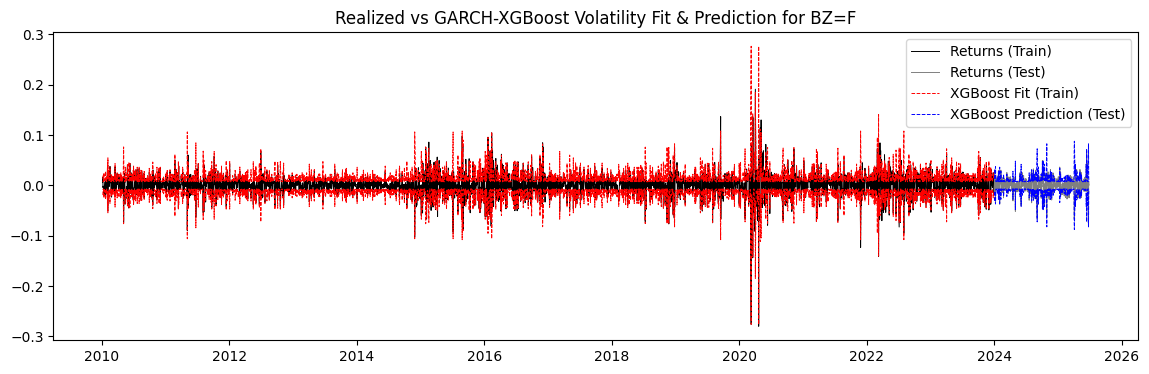

In [19]:
plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
# plt.plot(y_train_lagged.index.to_timestamp(), y_train_lagged.values, label='Realized Volatility (Train)', color='black', linewidth=0.7)
# plt.plot(y_test_lagged.index.to_timestamp(), y_test_lagged.values, label='Realized Volatility (Test)', color='gray', linewidth=0.7)
plt.plot(y_train_lagged.index.to_timestamp(), np.sqrt(y_pred_xgb_train), label='XGBoost Fit (Train)', color='red', linestyle='--', linewidth=0.7)
plt.plot(y_test_lagged.index.to_timestamp(), np.sqrt(y_pred_xgb), label='XGBoost Prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(y_train_lagged.index.to_timestamp(), -np.sqrt(y_pred_xgb_train), color='red', linestyle='--', linewidth=0.7)
plt.plot(y_test_lagged.index.to_timestamp(), -np.sqrt(y_pred_xgb), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"Realized vs GARCH-XGBoost Volatility Fit & Prediction for {TICKER}")
plt.legend()
plt.show()

### 2.4.2. GJR-GARCH - XGBoost

In [20]:
# Add GARCH volatility residuals as additional exogenous variables
# Prepare lagged features for XGBoost: use past days' returns as predictors
n_lags = 1

def make_lagged_features(series, n_lags):
    df = pd.concat([series.shift(i) for i in range(1, n_lags + 1)], axis=1)
    df.columns = [f"lag_{i}" for i in range(1, n_lags + 1)]
    return df

# Training set
X_train_lagged = make_lagged_features(train_returns, n_lags).dropna()
y_train_lagged = (train_returns ** 2).loc[X_train_lagged.index] # variance

# Test set
X_test_lagged = make_lagged_features(test_returns, n_lags).dropna()
y_test_lagged = (test_returns ** 2).loc[X_test_lagged.index] # variance

X_train_lagged['garch_resid'] = GJR_GARCH_volatility_residual_train.loc[X_train_lagged.index]
X_test_lagged['garch_resid'] = GJR_GARCH_volatility_residual_test.loc[X_test_lagged.index]

# Fit XGBoost regressor with the new feature
xgb = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
xgb.fit(X_train_lagged, y_train_lagged)

# Predict
y_pred_xgb = xgb.predict(X_test_lagged)

# Forecasted volatility (out-of-sample)
forecast_vol = np.sqrt(y_pred_xgb)
# Realized volatility
realized_vol = np.sqrt(y_test_lagged)

# Evaluate
mse_xgb = mean_squared_error(realized_vol, forecast_vol)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(realized_vol, forecast_vol)
corr_xgb = np.corrcoef(realized_vol, forecast_vol)[0, 1]


print(f"GJR_GARCH-XGBoost - MSE: {mse_xgb:.6f}")
print(f"GJR_GARCH-XGBoost - RMSE: {rmse_xgb:.6f}")
print(f"GJR_GARCH-XGBoost - MAE: {mae_xgb:.6f}")
print(f"GJR_GARCH-XGBoost - Correlation: {corr_xgb:.4f}")

# In-sample prediction (train set)
y_pred_xgb_train = xgb.predict(X_train_lagged)

GJR_GARCH-XGBoost - MSE: 0.000034
GJR_GARCH-XGBoost - RMSE: 0.005857
GJR_GARCH-XGBoost - MAE: 0.004348
GJR_GARCH-XGBoost - Correlation: 0.8900


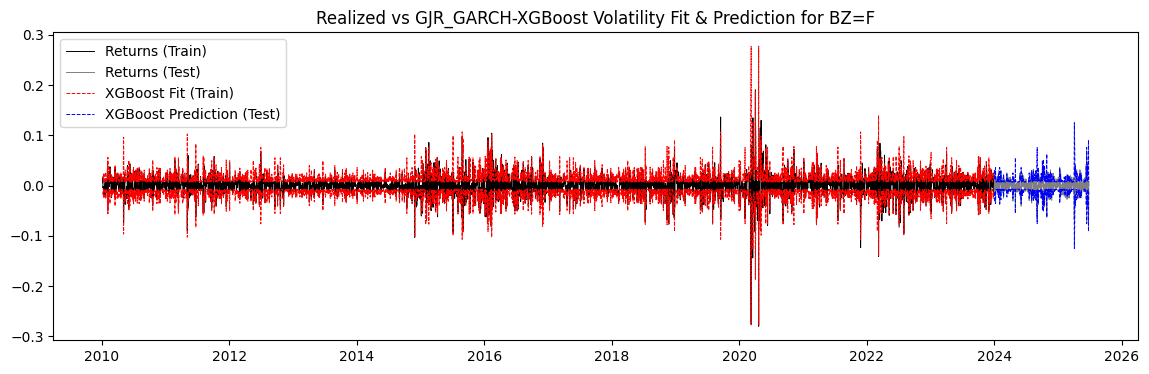

In [21]:
plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
# plt.plot(y_train_lagged.index.to_timestamp(), y_train_lagged.values, label='Realized Volatility (Train)', color='black', linewidth=0.7)
# plt.plot(y_test_lagged.index.to_timestamp(), y_test_lagged.values, label='Realized Volatility (Test)', color='gray', linewidth=0.7)
plt.plot(y_train_lagged.index.to_timestamp(), np.sqrt(y_pred_xgb_train), label='XGBoost Fit (Train)', color='red', linestyle='--', linewidth=0.7)
plt.plot(y_test_lagged.index.to_timestamp(), np.sqrt(y_pred_xgb), label='XGBoost Prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(y_train_lagged.index.to_timestamp(), -np.sqrt(y_pred_xgb_train), color='red', linestyle='--', linewidth=0.7)
plt.plot(y_test_lagged.index.to_timestamp(), -np.sqrt(y_pred_xgb), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"Realized vs GJR_GARCH-XGBoost Volatility Fit & Prediction for {TICKER}")
plt.legend()
plt.show()